In [1]:
import numpy as np
from keras.models import *
import glob
from keras.layers import Activation, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

C:\Python\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data processing

In [11]:
def create_dict_with_params(path):
    param_list = open(path, 'r').read().split('\n')
    param_list = list(map(lambda x: x.split(" = "), param_list))
    d = {x[0]:x[1] for x in param_list}
    int_params = ['batch_size', 'epochs', 'img_height', 'img_width',
                  'nb_train_samples', 'nb_validation_samples']
    for param in int_params:
        d[param] = int(d[param])
    d['without_augmentation'] = str_to_bool(d['without_augmentation'])
    if not d['without_augmentation']:
        gen_params = d['generator_params'][1:-1].split(",")
        new_d = {}
        for param in gen_params:
            key, value = param.split(" : ")
            new_d[key.strip()] = value
        gen_float_params  = ['height_shift_range', 'rotation_range',
                             'shear_range', 'width_shift_range', 'zoom_range']
        for param in gen_float_params:
            new_d[param] = float(new_d[param])
        new_d['horizontal_flip'] = str_to_bool(new_d['horizontal_flip'])
        d['generator_params'] = new_d
    return d

In [4]:
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False
    else:
         raise ValueError("Cannot covert {} to a bool".format(s))

## images size reduction

In [67]:
def load_data(data_path, rows, cols, img_type = "jpg"):
    imgs = glob.glob(data_path + "\\*" + img_type)
    img_count = len(imgs)
    imgs_data = np.ndarray((img_count, rows, cols, 3), dtype = np.uint8)
    for i in range(img_count):
        imgs_data[i, :, :] =  mpimg.imread(imgs[i])
    return imgs_data

In [139]:
def size_reduction(data, path, img_type = "jpg"):
    i = 1
    for img in data:
        im = Image.fromarray(img[128:-128,128:-128])
        im.save(path + str(i) + "." + img_type)
        i += 1

In [182]:
def size_reduction1(data, path, img_type = "jpg"):
    i = 1
    for img in data:
        im = Image.fromarray(img[32:-32,32:-32])
        im.save(path + str(i) + "." + img_type)
        i += 1

In [185]:
data = load_data("test",128,256)
size_reduction1(data, "test1/")

In [148]:
def apply_mask(path, mask_path, rows, cols, save_path, img_type = "jpg"):
    imgs = load_data(path, rows, cols, img_type)
    masks = load_data(mask_path, rows, cols, img_type)
    imgs = imgs.astype('float32')
    masks = masks.astype('float32')
    imgs /= 255
    masks /= 255
    masks[masks > 0.5] = 1
    masks[masks <= 0.5] = 0
    i = 1
    res = imgs * masks
    for img in res:
        print(img.shape)
        img = img * 255
        img = img.astype('uint8')
        img = Image.fromarray(img)
        img.save(save_path + str(i) + "." + img_type)
        i += 1

In [68]:
inp_path_0 = "data/with_masks/0_512"
out_path_0 = "data/with_masks/0_256/"
img_width = 512
img_height = 512 

data = load_data(inp_path_0, img_width, img_height)
size_reduction(data, out_path_0)

In [140]:
inp_path_1 = "data/with_masks/1_512"
out_path_1 = "data/with_masks/1_256/"
img_width = 512
img_height = 512 

data = load_data(inp_path_1, img_width, img_height)
size_reduction(data, out_path_1)

In [ ]:
img_path_0 = "data/with_masks/0_256"
mask_path_0 = "data/with_masks/masks_0/"
save_path_0 = "data/with_masks/result_0/"

img_path_1 = "data/with_masks/1_256"
mask_path_1 = "data/with_masks/masks_1/"
save_path_1 = "data/with_masks/result_1/"

img_width = 256
img_height = 256 

apply_mask(img_path_0, mask_path_0, img_width, img_height, save_path_0, img_type = "jpg")
apply_mask(img_path_1, mask_path_1, img_width, img_height, save_path_1, img_type = "jpg")

## data augmentation

In [2]:
def plots(ims, figsize=(12, 6), rows = 1):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize = figsize)
    cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        plt.imshow(ims[i])

In [3]:
def create_generator(data_dir, batch_size, img_width, img_height,
                     rotation_range = 0, width_shift_range = 0,
                     height_shift_range = 0, shear_range = 0,
                     zoom_range = 0, horizontal_flip = False):
    
    datagen = ImageDataGenerator(
        rescale = 1./255, rotation_range = rotation_range, width_shift_range = width_shift_range,
        height_shift_range = height_shift_range, shear_range = shear_range, zoom_range = zoom_range,
        horizontal_flip = horizontal_flip)

    generator = datagen.flow_from_directory(
        data_dir, target_size = (img_width, img_height),
        batch_size = batch_size, class_mode = 'binary')

    return generator

Found 182 images belonging to 2 classes.


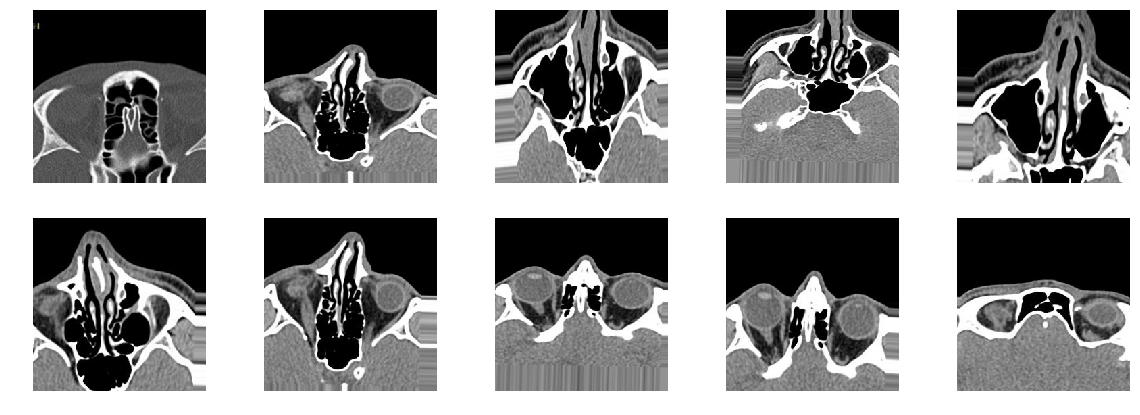

In [168]:
# data augmentation example
cfg_name = "cfg4.txt"
d = create_dict_with_params("cfg/" + cfg_name)
train_generator = create_generator(d["train_data_dir"], d["batch_size"], d["img_width"], d["img_height"], **d["generator_params"])
aug_images = [next(train_generator)[0][0] for i in range(10)]
plots(aug_images, figsize=(20,7), rows=2)

# Model

In [5]:
def get_model(img_width, img_height):
    model = Sequential()
    model.add(Conv2D(32, 11 ,activation = 'relu', input_shape = (img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(64, 3 ,activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3 ,activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3 ,activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation = 'relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy', recall_threshold()])
    return model

In [6]:
def create_logs(path, name, cfg_name, evaluation):
    info = "cfg name = " + cfg_name + "\n"
    for x in evaluation:
        info += (x[0] + " : " + str(x[1]) + "\n")
    with open(path + "/" + name + ".txt", 'w') as out:
        out.write(info)

# Main

In [8]:
def main(cfg_name, img_width, img_height, train_data_dir, validation_data_dir,
         nb_train_samples, result_name, nb_validation_samples, epochs, batch_size,
         without_augmentation, generator_params = None):
    
    model = get_model(img_width, img_height)

    if without_augmentation:
        train_generator = create_generator(train_data_dir, batch_size,
                                           img_width, img_height)
    else:
        train_generator = create_generator(train_data_dir, batch_size,
                                           img_width, img_height, **generator_params)

    validation_generator = create_generator(validation_data_dir, batch_size, img_width, img_height)

    model.fit_generator(
            train_generator, steps_per_epoch = nb_train_samples // batch_size,
            epochs = epochs, validation_data = validation_generator,
            validation_steps = nb_validation_samples // batch_size)
    
    evaluation = list(zip(model.metrics_names, model.evaluate_generator(validation_generator,
                                                          nb_validation_samples / batch_size)))
    create_logs("results", result_name, cfg_name, evaluation)
    model.save_weights("results/weights/weights" + result_name + ".h5")
    return model

In [159]:
cfg_name = "cfg_mask.txt"
d = create_dict_with_params("cfg/" + cfg_name)
model2 = main(cfg_name = cfg_name, **d)

Found 111 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/15
55/55 [==============================] - 34s 619ms/step - loss: 1.7753 - acc: 0.8727 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 2/15
55/55 [==============================] - 36s 659ms/step - loss: 1.6121 - acc: 0.9000 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 3/15
55/55 [==============================] - 34s 617ms/step - loss: 1.9049 - acc: 0.8818 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 4/15
55/55 [==============================] - 34s 621ms/step - loss: 1.6123 - acc: 0.9000 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 5/15
55/55 [==============================] - 35s 631ms/step - loss: 1.6121 - acc: 0.9000 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 6/15
55/55 [======

In [162]:
cfg_name = "cfg_mask1.txt"
d = create_dict_with_params("cfg/" + cfg_name)
model2 = main(cfg_name = cfg_name, **d)

Found 111 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/15
150/150 [==============================] - 92s 611ms/step - loss: 1.7340 - acc: 0.8833 - recall: 0.0067 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 2/15
150/150 [==============================] - 99s 657ms/step - loss: 1.6656 - acc: 0.8967 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 3/15
150/150 [==============================] - 90s 601ms/step - loss: 1.7727 - acc: 0.8900 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 4/15
150/150 [==============================] - 90s 602ms/step - loss: 1.8268 - acc: 0.8867 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 5/15
150/150 [==============================] - 91s 605ms/step - loss: 1.7193 - acc: 0.8933 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 6/15
150/150

In [166]:
cfg_name = "cfg_mask2.txt"
d = create_dict_with_params("cfg/" + cfg_name)
model3 = main(cfg_name = cfg_name, **d)

Found 111 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/15
150/150 [==============================] - 92s 614ms/step - loss: 1.7781 - acc: 0.8833 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 2/15
150/150 [==============================] - 91s 607ms/step - loss: 1.8268 - acc: 0.8867 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 3/15
150/150 [==============================] - 91s 604ms/step - loss: 1.6119 - acc: 0.9000 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 4/15
150/150 [==============================] - 91s 605ms/step - loss: 1.6656 - acc: 0.8967 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 5/15
150/150 [==============================] - 93s 621ms/step - loss: 1.9343 - acc: 0.8800 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 6/15
150

In [163]:
model2.save_weights("results/weights/weights_mask1.h5")

In [10]:
def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall